In [2]:
import numpy as np
import os
from tifffile import imread, imsave

import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from IPython.display import display

from scipy.ndimage.morphology import distance_transform_edt
import itk
import cv2


# from aicssegmentation.core.visual import blob2dExplorer_single, random_colormap
# from aicssegmentation.core.seg_dot import dot_2d
# from aicssegmentation.core.utils import hole_filling
# from aicssegmentation.core.pre_processing_utils import intensity_normalization, edge_preserving_smoothing_3d # , suggest_normalization_param, 

# sorry for no many comments

## I hate two things:
## 1. Write comments and documents
## 2. Others do not write comments and documents

In [3]:
plt.rcParams['figure.dpi'] = 200

In [4]:
def cmask(radius):
    kernel = np.zeros((2 * radius + 1, 2 * radius + 1), np.uint8)
    y, x = np.ogrid[-radius:radius + 1, -radius:radius + 1]
    mask = x ** 2 + y ** 2 <= radius ** 2
    kernel[mask] = 1
    return kernel

In [5]:
DATAPATH = "./Segmentation"

In [10]:
im_path = os.path.join(DATAPATH,'Vanderbilt_live_cell/17551485.tif')
im_path

'./Segmentation/Vanderbilt_live_cell/17551485.tif'

In [11]:
img = imread(im_path)

In [12]:
img.shape

(2160, 2160)

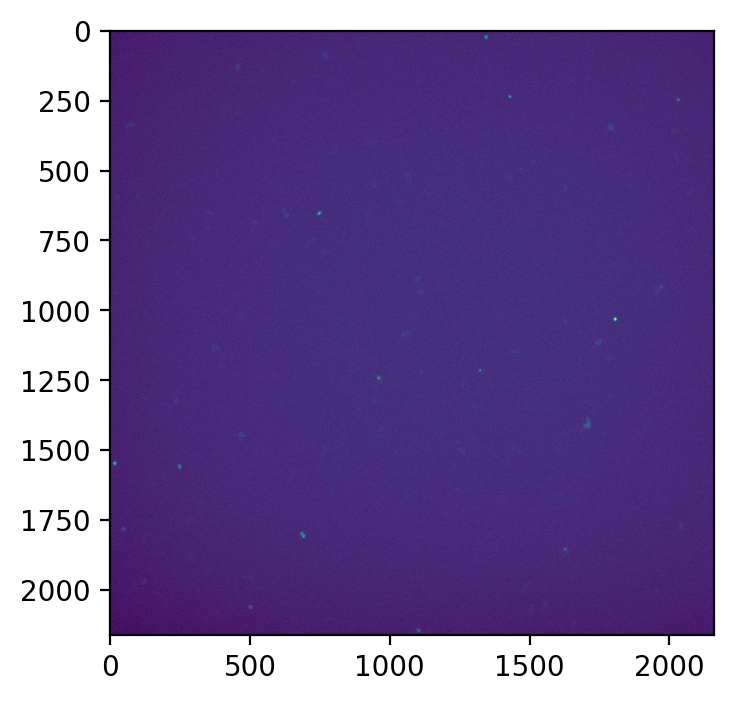

In [13]:
plt.imshow(img)

In [14]:
# from scipy.stats import norm
# from scipy.ndimage import gaussian_filter

# def suggest_normalization_param_return(structure_img0):
#     m, s = norm.fit(structure_img0.flat)
#     print(f'mean intensity of the stack: {m}')
#     print(f'the standard deviation of intensity of the stack: {s}')

#     p99 = np.percentile(structure_img0, 99.99)
#     print(f'0.9999 percentile of the stack intensity is: {p99}')

#     pmin = structure_img0.min()
#     print(f'minimum intensity of the stack: {pmin}')

#     pmax = structure_img0.max()
#     print(f'maximum intensity of the stack: {pmax}')

#     up_ratio = 0
#     for up_i in np.arange(0.5, 1000, 0.5):
#         if m+s * up_i > p99:
#             if m+s * up_i > pmax:
#                 print(f'suggested upper range is {up_i-0.5}, which is {m+s*(up_i-0.5)}')
#                 up_ratio = up_i-0.5
#             else:
#                 print(f'suggested upper range is {up_i}, which is {m+s*up_i}')
#                 up_ratio = up_i
#             break

#     low_ratio = 0
#     for low_i in np.arange(0.5, 1000, 0.5):
#         if m-s*low_i < pmin:
#             print(f'suggested lower range is {low_i-0.5}, which is {m-s*(low_i-0.5)}')
#             low_ratio = low_i-0.5
#             break
            
#     return [low_ratio, up_ratio]

In [15]:
# norm_para = suggest_normalization_param_return(img)

In [16]:
# img_norm = intensity_normalization(img, norm_para)

In [17]:
# img_smooth = edge_preserving_smoothing_3d(img_norm)

In [18]:
# plt.imshow(img_smooth)

In [19]:
bc_img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, cmask(20))

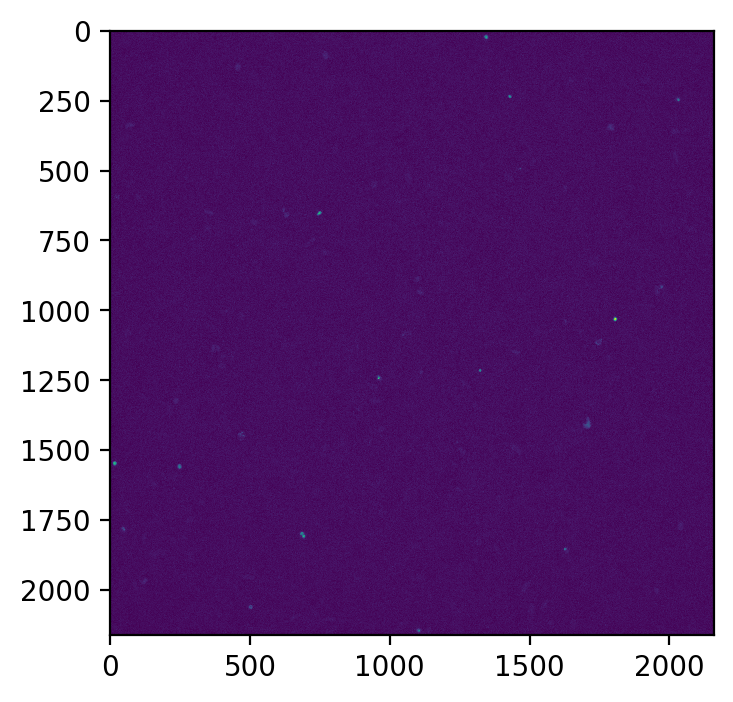

In [20]:
plt.imshow(bc_img)

In [21]:
# imsave("../temp/bc_img.tiff", bc_img)
# imsave("../temp/img_smooth.tiff", img_smooth)

In [22]:
from skimage.io import imread
import skimage

from skimage.morphology import disk
from skimage.filters.rank import gradient

import cv2
from skimage.measure import label
from skimage.color import label2rgb
from skimage.morphology import reconstruction

In [23]:
bc_img = skimage.img_as_float32(bc_img, force_copy=True)
# img_bl = cv2.GaussianBlur(bc_img, (7, 7), 0)
img_bl = cv2.bilateralFilter(bc_img,7,125,125)

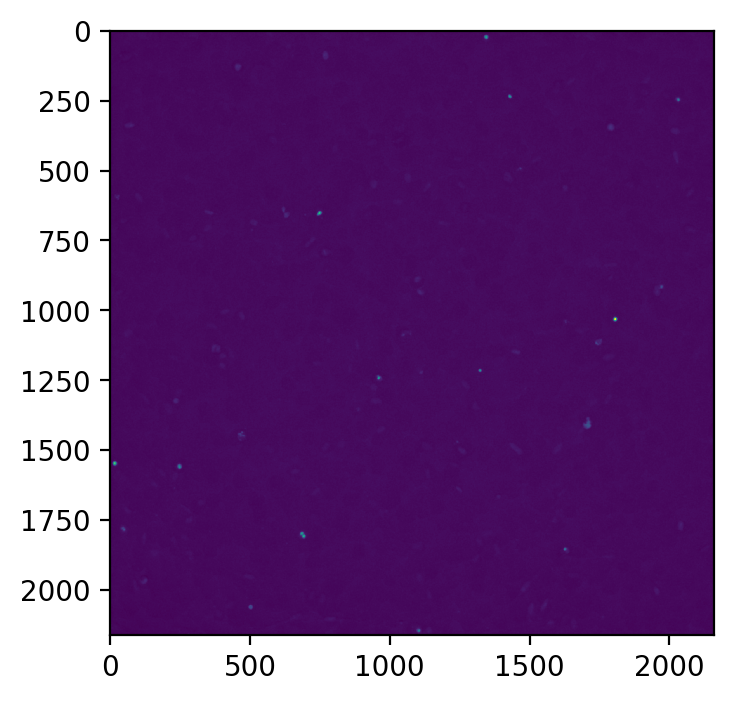

In [24]:
plt.imshow(img_bl)

In [25]:
ent = gradient(img_bl, disk(5))


Possible precision loss converting image of type float32 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.


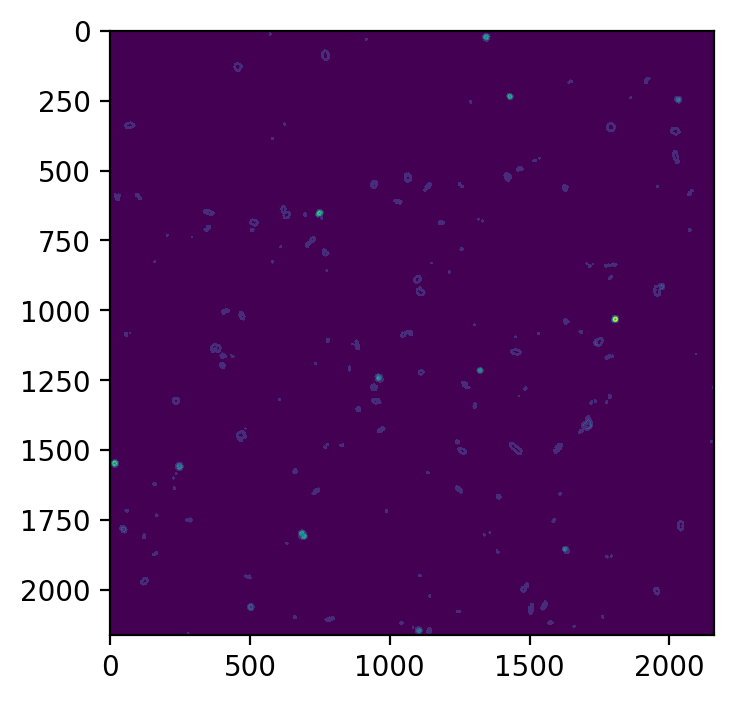

In [26]:
plt.imshow(ent)

In [27]:
seed = np.copy(ent)
seed[1:-1, 1:-1] = ent.max()
mask = ent

filled = reconstruction(seed, mask, method='erosion')

B = np.where(filled > 0, 1, 0)

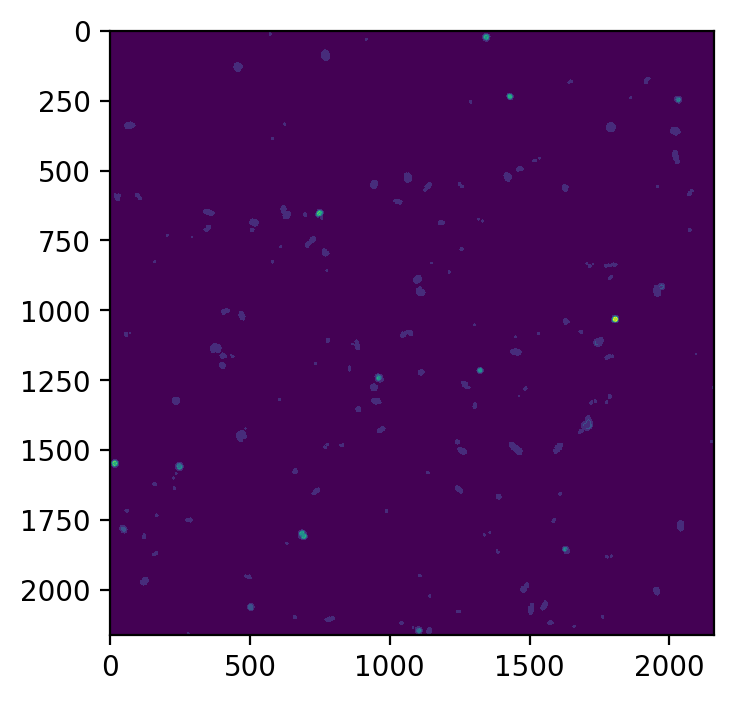

In [28]:
plt.imshow(filled)

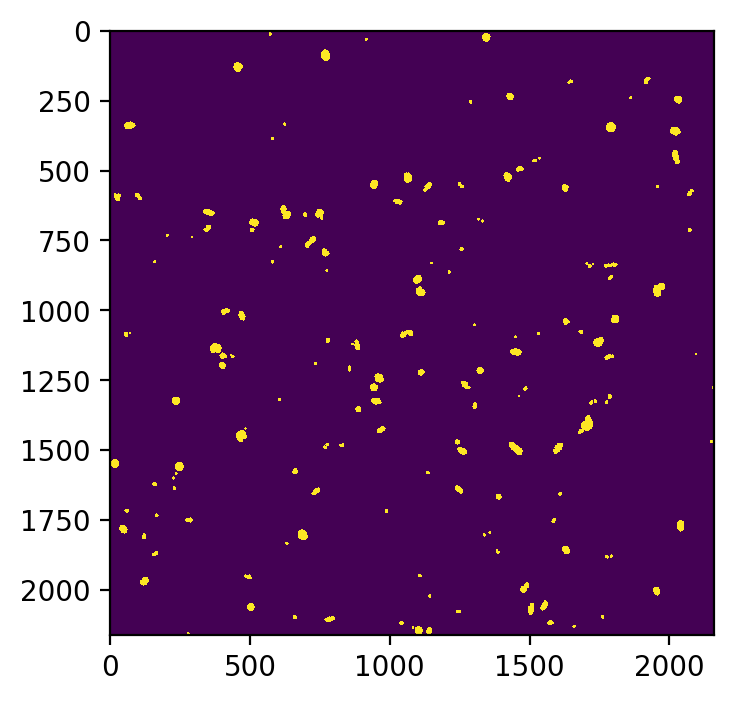

In [29]:
plt.imshow(B)

In [30]:
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max
distance = ndi.distance_transform_edt(filled)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((21, 21)),
                            labels=filled)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=filled)

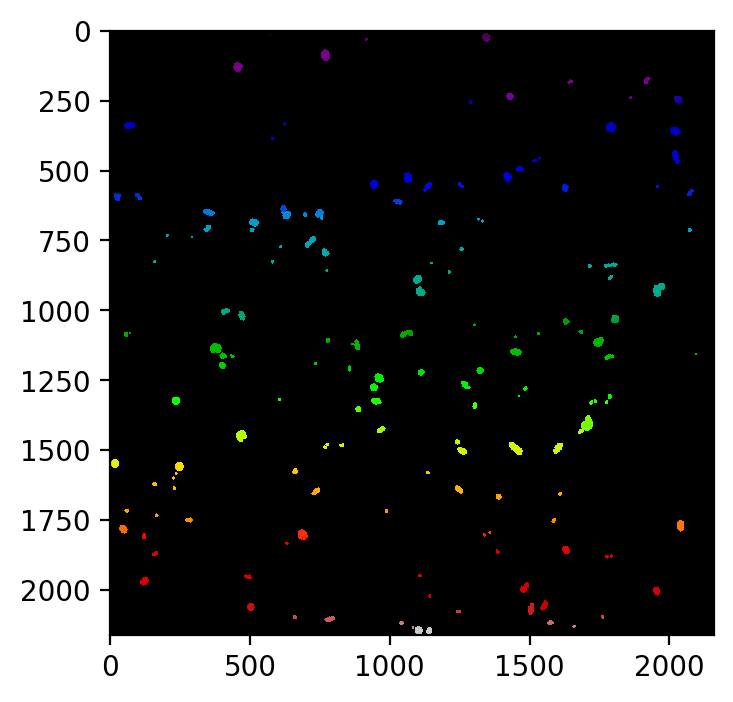

In [31]:
plt.imshow(labels, cmap=plt.cm.nipy_spectral)

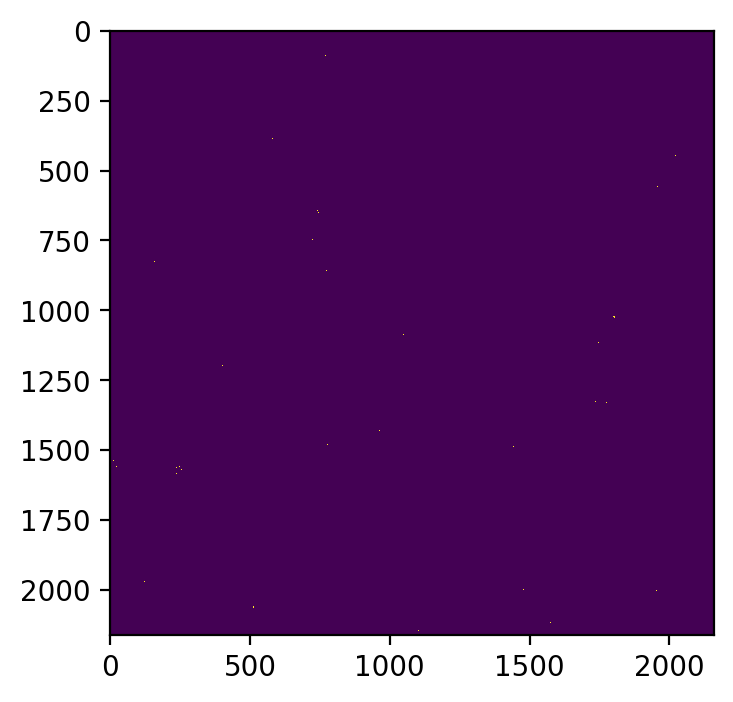

In [32]:
plt.imshow(local_maxi)

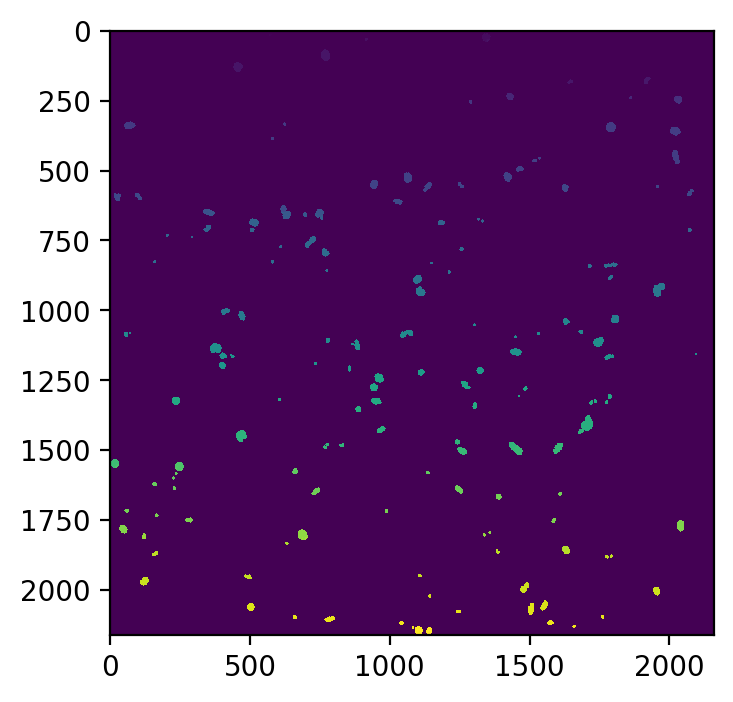

In [33]:
plt.imshow(labels)

In [34]:
imsave("../temp/temp.tiff", np.array(labels, dtype=np.uint16))

In [35]:
label_image = label(B)

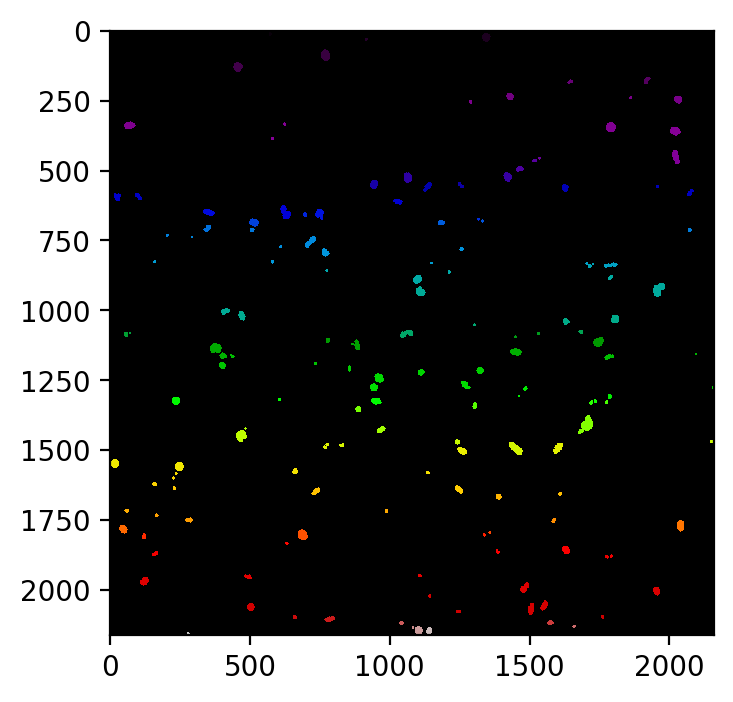

In [36]:
plt.imshow(label_image, cmap=plt.cm.nipy_spectral)

In [37]:
imsave("../temp/temp.tiff", np.array(label_image, dtype=np.uint16))

In [38]:
def nuclei_getter(img_path, output_path):
    img = imread(img_path)
    bc_img = cv2.morphologyEx(img, cv2.MORPH_TOPHAT, cmask(20))
    bc_img = skimage.img_as_float32(bc_img, force_copy=True)
    # img_bl = cv2.GaussianBlur(bc_img, (7, 7), 0)
    img_bl = cv2.bilateralFilter(bc_img,7,125,125)
    ent = gradient(img_bl, disk(5))
    seed = np.copy(ent)
    seed[1:-1, 1:-1] = ent.max()
    mask = ent

    filled = reconstruction(seed, mask, method='erosion')

    B = np.where(filled > 0, 1, 0)
    label_image = label(B)
    imsave(output_path, np.array(label_image, dtype=np.uint16))

In [36]:
import time
in_dir = "./Segmentation/Vanderbilt_live_cell"
out_dir = "../temp/live_cell_processed"
file_lists = os.listdir(in_dir)
count = 0
start = time.time()
for file in file_lists:
    in_path = os.path.join(in_dir,file)
    out_path = os.path.join(out_dir,file.replace(".tif","_Nuclear_segmentation_map.tif"))
    # print(f"{in_path} -> {out_path}")
    nuclei_getter(in_path, out_path)
    count += 1
    if count % 100 == 0:
        end = time.time()
        print(f"{count}: {end-start} seconds")
        start = end

100: 239.65624451637268 seconds
200: 240.858989238739 seconds
300: 236.26059865951538 seconds
400: 235.54380083084106 seconds
500: 233.27623081207275 seconds
600: 233.84027194976807 seconds
700: 239.49275469779968 seconds
800: 233.05129170417786 seconds
900: 232.84044647216797 seconds
1000: 233.89961409568787 seconds
1100: 233.00569939613342 seconds
1200: 239.54688835144043 seconds
1300: 251.20053219795227 seconds
1400: 252.7991542816162 seconds
1500: 246.23501467704773 seconds
1600: 240.4820692539215 seconds
1700: 237.73338627815247 seconds
1800: 243.22530484199524 seconds
1900: 237.98507022857666 seconds
2000: 239.86593103408813 seconds
2100: 240.22510075569153 seconds
2200: 238.57557725906372 seconds
2300: 237.99921584129333 seconds
2400: 238.29171347618103 seconds
2500: 238.7319254875183 seconds
2600: 237.6751470565796 seconds
2700: 241.22368693351746 seconds
2800: 238.19161677360535 seconds
2900: 243.1786437034607 seconds
3000: 242.2494671344757 seconds
3100: 242.69351935386658 se